# Rainfall-Classification-Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.pipeline import Pipeline

# Functions

In [6]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/rainfall.csv")
df

,date,rainfall,temperature,humidity,wind_speed,weather_condition
0,2022-01-01,12.5,15.2,78.0,8.5,Rainy
1,2022-01-02,8.2,17.8,65.0,5.2,Rainy
2,2022-01-03,0.0,20.1,52.0,3.1,Sunny
3,2022-01-04,3.7,18.6,71.0,6.7,Rainy
4,2022-01-05,21.1,14.8,82.0,9.3,Rainy
5,2022-01-06,15.3,16.5,75.0,7.8,Rainy
6,2022-01-07,6.8,19.2,61.0,4.5,Rainy
7,2022-01-08,0.0,21.7,48.0,2.9,Sunny
8,2022-01-09,11.2,17.3,73.0,6.1,Rainy
9,2022-01-10,18.6,15.8,79.0,8.9,Rainy


In [5]:
df.dropna(inplace=True)

# Check Class Imbalance

Class=Rainy, Count=42, Percentage=79.245%
Class=Sunny, Count=11, Percentage=20.755%


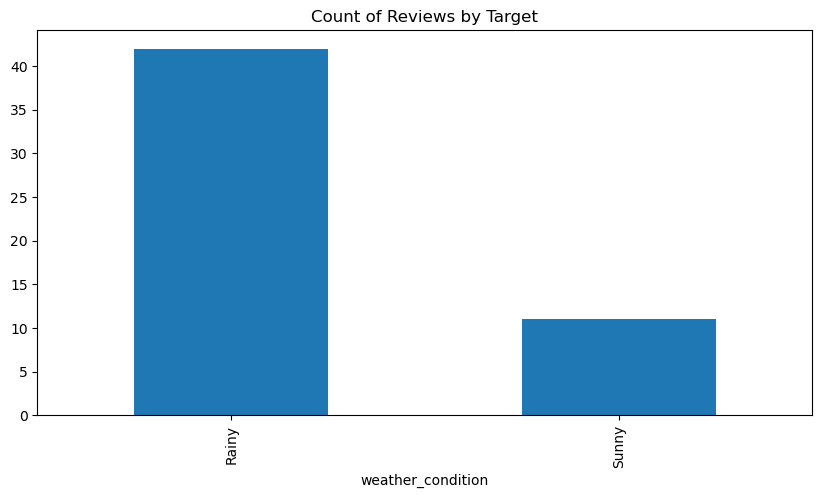

In [7]:
check_class_imbalance(df, df["weather_condition"], "weather_condition")